In [ ]:
%%writefile train_jigsaw_model.py

# --- LOCAL IMPORTS ---
import modal
import torch

# --- MODAL SETUP ---
image = modal.Image.debian_slim().pip_install(
    "numpy<2.0", "networkx==3.2.1", "pymetis==2022.1", "torch==2.2.1",
    "torch_geometric==2.5.2", "torch-scatter==2.1.2", "torch-sparse==0.6.18",
    find_links="https://data.pyg.org/whl/torch-2.2.1+cu121.html"
)
app = modal.App("subgnn-jigsaw-training", image=image)

# --- THE REMOTE TRAINING FUNCTION ---
@app.function(gpu="a100", timeout=7200)
def train(epochs, steps_per_epoch, batch_size, num_hierarchies=3):
    # --- REMOTE-ONLY IMPORTS and DEFINITIONS ---
    import torch
    import torch.nn.functional as F
    from torch.nn import Dropout, LeakyReLU, Linear, ReLU, Sequential
    from torch_geometric.datasets import CoraFull
    from torch_geometric.nn import GINConv, global_mean_pool
    from torch_geometric.utils import k_hop_subgraph, to_networkx, to_undirected
    from torch_geometric.data import Batch
    import networkx as nx
    import pymetis
    import random
    from collections import Counter, defaultdict
    import itertools

    # --- MODEL ARCHITECTURE ---
    class SubgraphEncoder(torch.nn.Module):
        def __init__(self, in_neurons, hidden_neurons, output_neurons):
            super().__init__()
            nn1 = Sequential(Linear(in_neurons, hidden_neurons), ReLU(), Linear(hidden_neurons, hidden_neurons))
            self.conv1 = GINConv(nn1); self.bn1 = torch.nn.BatchNorm1d(hidden_neurons)
            nn2 = Sequential(Linear(hidden_neurons, hidden_neurons), ReLU(), Linear(hidden_neurons, hidden_neurons))
            self.conv2 = GINConv(nn2); self.bn2 = torch.nn.BatchNorm1d(hidden_neurons)
            nn3 = Sequential(Linear(hidden_neurons, hidden_neurons), ReLU(), Linear(hidden_neurons, hidden_neurons))
            self.conv3 = GINConv(nn3); self.bn3 = torch.nn.BatchNorm1d(hidden_neurons)
            self.lin = Linear(hidden_neurons * 3, output_neurons)
        def forward(self, x, edge_index, batch):
            h1 = F.relu(self.bn1(self.conv1(x, edge_index)))
            h2 = F.relu(self.bn2(self.conv2(h1, edge_index)))
            h3 = F.relu(self.bn3(self.conv3(h2, edge_index)))
            h_final = torch.cat([global_mean_pool(h1, batch), global_mean_pool(h2, batch), global_mean_pool(h3, batch)], dim=1)
            return F.normalize(self.lin(h_final), dim=1)

    # --- HIERARCHICAL LOSS ---
    def info_nce_loss(queries, positives, temperature=0.1):
        logits = torch.matmul(queries, positives.T) / temperature
        labels = torch.arange(len(queries), device=queries.device)
        return F.cross_entropy(logits, labels)
    def hierarchical_info_nce_loss(zq, z_fine, z_coarse, temperature=0.1, alpha=0.5):
        loss_fine = info_nce_loss(zq, z_fine, temperature)
        loss_coarse = info_nce_loss(zq, z_coarse, temperature)
        return (alpha * loss_fine) + ((1 - alpha) * loss_coarse)

    # --- DATA PARTITIONING AND HIERARCHY HELPERS ---
    def make_partitions(dataset, num_parts):
        if dataset.num_nodes < num_parts: num_parts = dataset.num_nodes
        if num_parts <= 1: return [dataset], {0: torch.arange(dataset.num_nodes, device=dataset.x.device)}
        adj = to_networkx(dataset, to_undirected=True).adjacency()
        adj_list = [list(neighbors) for _, neighbors in adj]
        _, membership = pymetis.part_graph(num_parts, adjacency=adj_list)
        part_graphs, part_nodes_map = [], {}
        for part_id in range(num_parts):
            node_indices = [i for i, p in enumerate(membership) if p == part_id]
            if node_indices:
                nodes_tensor = torch.tensor(node_indices, dtype=torch.long, device=dataset.x.device)
                part_nodes_map[part_id] = nodes_tensor
                # WORKAROUND: Use boolean mask for subgraphing on GPU to avoid PyG bug
                mask = torch.zeros(dataset.num_nodes, dtype=torch.bool, device=dataset.x.device)
                mask[nodes_tensor] = True
                part_graphs.append(dataset.subgraph(mask))
        return part_graphs, part_nodes_map

    def build_single_hierarchy(data, num_coarse, num_fine):
        print(f"\n  • Building hierarchy with {num_coarse} coarse and {num_coarse*num_fine} fine partitions...")
        coarse_graphs, coarse_part_nodes_map = make_partitions(data, num_coarse)
        node_to_coarse_map = {}
        for coarse_id, nodes in coarse_part_nodes_map.items():
            for node_idx in nodes: node_to_coarse_map[node_idx.item()] = coarse_id
        coarse_part_graph = nx.Graph()
        for u, v in data.edge_index.t().tolist():
            c_u, c_v = node_to_coarse_map.get(u), node_to_coarse_map.get(v)
            if c_u is not None and c_v is not None and c_u != c_v:
                coarse_part_graph.add_edge(c_u, c_v)
        fine_graphs, fine_part_nodes_map, fine_to_coarse_map = [], {}, {}
        fine_global_idx = 0
        for coarse_idx, coarse_graph in enumerate(coarse_graphs):
            if coarse_idx not in coarse_part_nodes_map: continue
            global_nodes_of_this_coarse_part = coarse_part_nodes_map[coarse_idx]
            if coarse_graph.num_nodes < (num_fine * 2) or coarse_graph.num_edges == 0:
                finer_partitions, finer_nodes_map_local = [coarse_graph], {0: torch.arange(coarse_graph.num_nodes, device=data.x.device)}
            else:
                finer_partitions, finer_nodes_map_local = make_partitions(coarse_graph, num_fine)
            for fine_local_idx, fine_part in enumerate(finer_partitions):
                if fine_local_idx not in finer_nodes_map_local: continue
                local_indices_in_coarse = finer_nodes_map_local[fine_local_idx]
                global_indices_for_fine = global_nodes_of_this_coarse_part[local_indices_in_coarse]
                if fine_part.num_nodes > 10 and fine_part.num_edges > 0:
                    fine_graphs.append(fine_part)
                    fine_part_nodes_map[fine_global_idx] = global_indices_for_fine
                    fine_to_coarse_map[fine_global_idx] = coarse_idx
                    fine_global_idx += 1
        print(f"    - Created {len(fine_graphs)} usable fine partitions and a coarse graph with {coarse_part_graph.number_of_nodes()} nodes and {coarse_part_graph.number_of_edges()} edges.")
        return coarse_graphs, fine_graphs, node_to_coarse_map, fine_to_coarse_map, fine_part_nodes_map, coarse_part_graph, coarse_part_nodes_map

    def build_multiple_hierarchies(data, n_hierarchies):
        print(f"[SETUP] Building {n_hierarchies} different hierarchies for Jigsaw training...")
        hierarchies = []
        for i in range(n_hierarchies):
            num_coarse = random.randint(10, 70)
            num_fine = random.randint(5, 10)
            hierarchy_data = build_single_hierarchy(data, num_coarse, num_fine)
            hierarchies.append(hierarchy_data)
        return hierarchies

    # --- DATA GENERATION HELPERS ---
    def _extract_fragment(source_graph, target_size):
        if source_graph.num_nodes < target_size / 2: return None
        source_nx = to_networkx(source_graph, to_undirected=True)
        if not nx.is_connected(source_nx):
            try: largest_cc_nodes = max(nx.connected_components(source_nx), key=len)
            except ValueError: return None
            source_nx = source_nx.subgraph(largest_cc_nodes)
        if source_nx.number_of_nodes() == 0: return None
        start_node = random.choice(list(source_nx.nodes()))
        q_nodes = list(nx.bfs_tree(source_nx, start_node, depth_limit=5).nodes())[:target_size]
        if len(q_nodes) < target_size / 2: return None
        return torch.tensor(q_nodes, dtype=torch.long)

    def _finalize_query_from_nodes(original_data, global_node_indices, min_nodes):
        if not global_node_indices: return None, None
        q_global_nodes = torch.tensor(list(set(global_node_indices)), dtype=torch.long, device=original_data.x.device)
        if len(q_global_nodes) < min_nodes: return None, None
        # WORKAROUND: Use boolean mask for subgraphing on GPU to avoid PyG bug
        mask = torch.zeros(original_data.num_nodes, dtype=torch.bool, device=original_data.x.device)
        mask[q_global_nodes] = True
        return original_data.subgraph(mask), q_global_nodes

    def are_partitions_neighbors(G_nx, nodes1, nodes2):
        nodes2_set = set(nodes2.tolist())
        for node in nodes1:
            for neighbor in G_nx.neighbors(node.item()):
                if neighbor in nodes2_set: return True
        return False

    # --- MODIFIED: FUNCTION WITH RANDOMIZED-ENTRY FALLBACK ---
    def generate_multi_coarse_partition_query(
        original_data, G_nx, coarse_part_graph, fine_graphs, fine_part_nodes_map, fine_to_coarse_map,
        min_nodes=80, max_nodes=100
    ):
        if coarse_part_graph.number_of_edges() == 0:
            raise RuntimeError("Coarse graph has no edges.")
        configurations = [(4, 4), (4, 3), (3, 3), (4, 2), (3, 2), (2, 2)]
        start_index = random.randint(0, len(configurations) - 1)
        reordered_configs_to_try = configurations[start_index:] + configurations[:start_index]
        coarse_to_fine_map = defaultdict(list)
        for f_idx, c_idx in fine_to_coarse_map.items(): coarse_to_fine_map[c_idx].append(f_idx)
        for num_frags, min_coarse_parts in reordered_configs_to_try:
            possible_start_edges = list(coarse_part_graph.edges())
            random.shuffle(possible_start_edges)
            for c_idx1, c_idx2 in possible_start_edges:
                fine_parts_in_c1 = coarse_to_fine_map.get(c_idx1, [])
                fine_parts_in_c2 = coarse_to_fine_map.get(c_idx2, [])
                all_fine_pairs = list(itertools.product(fine_parts_in_c1, fine_parts_in_c2))
                random.shuffle(all_fine_pairs)
                for f1, f2 in all_fine_pairs:
                    if not are_partitions_neighbors(G_nx, fine_part_nodes_map[f1], fine_part_nodes_map[f2]): continue
                    q_fine_indices, queue, visited = [f1, f2], [f1, f2], {f1, f2}
                    while queue and len(q_fine_indices) < num_frags:
                        current_fine_idx = queue.pop(0)
                        current_c_idx = fine_to_coarse_map[current_fine_idx]
                        coarse_neighbors_and_self = list(coarse_part_graph.neighbors(current_c_idx)) + [current_c_idx]
                        potential_fine_neighbors = [fn for c_idx in coarse_neighbors_and_self for fn in coarse_to_fine_map.get(c_idx, [])]
                        random.shuffle(potential_fine_neighbors)
                        for neighbor_idx in potential_fine_neighbors:
                            if neighbor_idx not in visited and are_partitions_neighbors(G_nx, fine_part_nodes_map[current_fine_idx], fine_part_nodes_map[neighbor_idx]):
                                visited.add(neighbor_idx); queue.append(neighbor_idx); q_fine_indices.append(neighbor_idx)
                                if len(q_fine_indices) >= num_frags: break
                    if len(q_fine_indices) < num_frags: continue
                    true_coarse_indices = {fine_to_coarse_map[f_idx] for f_idx in q_fine_indices}
                    if len(true_coarse_indices) < min_coarse_parts: continue
                    nodes_per_frag = max_nodes // num_frags
                    all_query_nodes = []
                    for fine_idx in q_fine_indices:
                        local_nodes = _extract_fragment(fine_graphs[fine_idx], nodes_per_frag)
                        if local_nodes is not None:
                            all_query_nodes.extend(fine_part_nodes_map[fine_idx][local_nodes].tolist())
                    Gq, _ = _finalize_query_from_nodes(original_data, all_query_nodes, min_nodes)
                    if Gq:
                        stitched_nodes = torch.cat([fine_part_nodes_map[idx] for idx in q_fine_indices])
                        # WORKAROUND: Use boolean mask for subgraphing on GPU to avoid PyG bug
                        mask = torch.zeros(original_data.num_nodes, dtype=torch.bool, device=original_data.x.device)
                        mask[stitched_nodes] = True
                        G_stitched = original_data.subgraph(mask)
                        return Gq, G_stitched, true_coarse_indices
        raise RuntimeError("Failed to generate multi-coarse-partition query after trying all valid configurations.")

    def generate_hierarchical_sample(
        original_data, G_nx, coarse_graphs, fine_graphs,
        node_to_coarse_map, fine_to_coarse_map, fine_part_nodes_map,
        coarse_part_nodes_map, coarse_part_graph,
        k=6, q_size_min=20, q_size_max=100,
        prob_k_hop=0.4, prob_single_part=0.2, prob_multi_coarse=0.2,
        max_gpos_nodes=4000
    ):
        rand_choice = random.random()
        device = original_data.x.device
        Gq, Gpos, G_coarse_pos = None, None, None

        if rand_choice < prob_k_hop: # View 1: K-hop subgraph
            anchor = random.randint(0, original_data.num_nodes - 1)
            subset_pos, _, _, _ = k_hop_subgraph(anchor, k, original_data.edge_index, relabel_nodes=False)
            if len(subset_pos) < q_size_min or len(subset_pos) > max_gpos_nodes: return None
            # WORKAROUND: Use a boolean mask for subgraphing on GPU to avoid PyG bug
            pos_mask = torch.zeros(original_data.num_nodes, dtype=torch.bool, device=device)
            pos_mask[subset_pos] = True
            Gpos = original_data.subgraph(pos_mask)
            parent_counts = Counter(node_to_coarse_map.get(node_id.item()) for node_id in subset_pos)
            if not parent_counts: return None
            coarse_parent_idx = parent_counts.most_common(1)[0][0]
            if coarse_parent_idx is None: return None

            # --- START FIX ---
            # The original `Gpos.subgraph(indices_tensor)` call caused the error due to a
            # device mismatch bug in this PyG version. The fix is to manually create a
            # boolean mask on the correct device (GPU) before calling subgraph.
            q_nodes_local_indices = torch.randperm(Gpos.num_nodes)[:random.randint(q_size_min, min(q_size_max, Gpos.num_nodes))]
            q_mask = torch.zeros(Gpos.num_nodes, dtype=torch.bool, device=device)
            q_mask[q_nodes_local_indices.to(device)] = True
            Gq = Gpos.subgraph(q_mask)
            # --- END FIX ---

            G_coarse_pos = coarse_graphs[coarse_parent_idx]

        elif rand_choice < prob_k_hop + prob_single_part: # View 2: Single fine partition
            if not fine_graphs: return None
            fine_idx = random.choice(list(fine_to_coarse_map.keys()))
            Gpos = fine_graphs[fine_idx]
            if Gpos.num_nodes > max_gpos_nodes: return None
            q_nodes_local = _extract_fragment(Gpos, random.randint(q_size_min, q_size_max))
            if q_nodes_local is None: return None
            # WORKAROUND: Use boolean mask for subgraphing on GPU to avoid PyG bug
            q_mask = torch.zeros(Gpos.num_nodes, dtype=torch.bool, device=device)
            q_mask[q_nodes_local.to(device)] = True
            Gq = Gpos.subgraph(q_mask)
            coarse_parent_idx = fine_to_coarse_map.get(fine_idx)
            if coarse_parent_idx is None: return None
            G_coarse_pos = coarse_graphs[coarse_parent_idx]

        elif rand_choice < prob_k_hop + prob_single_part + prob_multi_coarse: # View 3: Multi-coarse query
            try:
                Gq, Gpos, coarse_indices = generate_multi_coarse_partition_query(
                    original_data, G_nx, coarse_part_graph, fine_graphs,
                    fine_part_nodes_map, fine_to_coarse_map,
                    min_nodes=q_size_min, max_nodes=q_size_max
                )
                all_coarse_pos_nodes = torch.cat([coarse_part_nodes_map[c_idx] for c_idx in coarse_indices])
                # WORKAROUND: Use boolean mask for subgraphing on GPU to avoid PyG bug
                coarse_mask = torch.zeros(original_data.num_nodes, dtype=torch.bool, device=device)
                coarse_mask[all_coarse_pos_nodes] = True
                G_coarse_pos = original_data.subgraph(coarse_mask)
            except RuntimeError:
                return None

        else: # View 4: Stitched from neighboring fine partitions within the SAME coarse parent
            if not fine_part_nodes_map or len(fine_part_nodes_map) < 2: return None
            num_frags = random.randint(2, 3)
            start_fine_idx = random.choice(list(fine_part_nodes_map.keys()))
            coarse_parent_idx = fine_to_coarse_map.get(start_fine_idx)
            if coarse_parent_idx is None: return None
            siblings = [idx for idx, c_idx in fine_to_coarse_map.items() if c_idx == coarse_parent_idx]
            source_part_indices = {start_fine_idx}
            queue = [start_fine_idx]
            while queue and len(source_part_indices) < num_frags:
                curr_idx = queue.pop(0); random.shuffle(siblings)
                for neighbor_idx in siblings:
                    if neighbor_idx not in source_part_indices and are_partitions_neighbors(G_nx, fine_part_nodes_map[curr_idx], fine_part_nodes_map[neighbor_idx]):
                        source_part_indices.add(neighbor_idx); queue.append(neighbor_idx)
                        if len(source_part_indices) >= num_frags: break
            if len(source_part_indices) < num_frags: return None
            pos_nodes = torch.cat([fine_part_nodes_map[i] for i in source_part_indices])
            if len(pos_nodes) > max_gpos_nodes: return None
            # WORKAROUND: Use boolean mask for subgraphing on GPU to avoid PyG bug
            pos_mask = torch.zeros(original_data.num_nodes, dtype=torch.bool, device=device)
            pos_mask[pos_nodes] = True
            Gpos = original_data.subgraph(pos_mask)
            nodes_per_frag = (q_size_min + q_size_max) // (2 * num_frags)
            all_query_global_nodes = []
            for fine_idx in source_part_indices:
                local_indices = _extract_fragment(fine_graphs[fine_idx], nodes_per_frag)
                if local_indices is None: return None
                all_query_global_nodes.extend(fine_part_nodes_map[fine_idx][local_indices].tolist())
            Gq, _ = _finalize_query_from_nodes(original_data, all_query_global_nodes, q_size_min)
            if Gq is None: return None
            G_coarse_pos = coarse_graphs[coarse_parent_idx]

        if Gq is None or Gpos is None or G_coarse_pos is None: return None
        return Gq, Gpos, G_coarse_pos

    # --- CORE TRAINING LOGIC ---
    device = torch.device("cuda")
    dataset = CoraFull(root="/tmp/Cora")[0].to(device)
    print(f"[REMOTE INFO] Using device: {device}")

    encoder = SubgraphEncoder(dataset.num_features, 64, 16).to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    encoder.train()

    hierarchies = build_multiple_hierarchies(dataset, num_hierarchies)
    G_nx = to_networkx(dataset, to_undirected=True)

    print("-" * 50)
    for epoch in range(epochs):
        total_loss = 0
        for step in range(steps_per_epoch):
            query_graphs, pos_graphs, coarse_pos_graphs = [], [], []

            chosen_hierarchy = random.choice(hierarchies)
            (coarse_graphs, fine_graphs, node_to_coarse_map, fine_to_coarse_map,
             fine_part_nodes_map, coarse_part_graph, coarse_part_nodes_map) = chosen_hierarchy

            while len(query_graphs) < batch_size:
                sample = generate_hierarchical_sample(
                    dataset, G_nx, coarse_graphs, fine_graphs,
                    node_to_coarse_map, fine_to_coarse_map, fine_part_nodes_map,
                    coarse_part_nodes_map, coarse_part_graph
                )
                if sample:
                    gq, gpos, g_coarse = sample
                    if gq.num_nodes > 1 and gpos.num_nodes > 1 and g_coarse.num_nodes > 1:
                        query_graphs.append(gq); pos_graphs.append(gpos); coarse_pos_graphs.append(g_coarse)

            if not query_graphs:
                print(f"Warning: No valid samples generated in step {step+1} of epoch {epoch+1}. Skipping batch.")
                continue

            query_batch = Batch.from_data_list(query_graphs)
            pos_batch = Batch.from_data_list(pos_graphs)
            coarse_pos_batch = Batch.from_data_list(coarse_pos_graphs)

            zq = encoder(query_batch.x, query_batch.edge_index, query_batch.batch)
            z_pos = encoder(pos_batch.x, pos_batch.edge_index, pos_batch.batch)
            z_coarse = encoder(coarse_pos_batch.x, coarse_pos_batch.edge_index, coarse_pos_batch.batch)

            loss = hierarchical_info_nce_loss(zq, z_pos, z_coarse)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / steps_per_epoch if steps_per_epoch > 0 else 0
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs}: Avg Loss = {avg_loss:.6f}, LR = {current_lr:.1e}")

    print("\n[REMOTE INFO] Training finished.")
    encoder.to('cpu')
    return encoder.state_dict()

# --- THE LOCAL ENTRYPOINT ---
@app.local_entrypoint()
def main():
    print("🚀 Starting Jigsaw GNN training on Modal...")
    model_state_dict = train.remote(
        epochs=150,
        steps_per_epoch=50,
        batch_size=32,
        num_hierarchies=5
    )
    file_path = "cora-model-jigsaw-multicoarse.pth"
    torch.save(model_state_dict, file_path)
    print(f"✅ Model saved to '{file_path}'")

Writing train_jigsaw_model.py


In [ ]:
# !pip install modal
# !modal token set --token-id "write your own" --token-secret "write your own"

In [ ]:
# !modal run train_jigsaw_model.py

In [ ]:
!pip install torch_geometric
!pip install faiss-cpu
!pip install pymetis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vf3py: filename=vf3py-1.0.2-py3-none-any.whl size=481480 sha256=e556b13f2fb4f9acbeab65822ec9ed09dc59121714f3dcf99fdbc3207bef168d
  Stored in directory: /root/.cache/pip/wheels/64/53/65/adc9cc99d0ec930cd525ca67d0e6973dedb7d5daf416ba64b5
Successfully built vf3py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.7/273.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
# --- Imports ---
import random
import time
import faiss
import networkx as nx
import pymetis
import torch
import torch.nn.functional as F
from torch.nn import Dropout, LeakyReLU, Linear, ReLU, Sequential
from torch_geometric.datasets import CoraFull
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import tqdm
import itertools
from collections import defaultdict

# --- Dataset and Device Setup ---
# Load the CoraFull dataset
DATASET = CoraFull(root="/tmp/Cora")[0]

# Set device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = DATASET.to(device)
print(f"[INFO] Using device: {device}")
print("-" * 50)
print("CoraFull Dataset Details")
print(f"  • Nodes:    {DATASET.num_nodes}")
print(f"  • Edges:    {DATASET.num_edges}")
print(f"  • Features: {DATASET.num_features}")
print("-" * 50)

Processing...
Done!


[INFO] Using device: cpu
--------------------------------------------------
CoraFull Dataset Details
  • Nodes:    19793
  • Edges:    126842
  • Features: 8710
--------------------------------------------------


In [ ]:
# --- GNN Model and Helper Functions ---
class SubgraphEncoder(torch.nn.Module):
    def __init__(self, in_neurons, hidden_neurons, output_neurons):
        super().__init__()

        # Layer 1
        nn1 = Sequential(Linear(in_neurons, hidden_neurons), ReLU(), Linear(hidden_neurons, hidden_neurons))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(hidden_neurons)

        # Layer 2
        nn2 = Sequential(Linear(hidden_neurons, hidden_neurons), ReLU(), Linear(hidden_neurons, hidden_neurons))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_neurons)

        # Layer 3
        nn3 = Sequential(Linear(hidden_neurons, hidden_neurons), ReLU(), Linear(hidden_neurons, hidden_neurons))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(hidden_neurons)

        # The final linear layer takes the concatenated embeddings from all layers
        self.lin = Linear(hidden_neurons * 3, output_neurons)

    def forward(self, x, edge_index, batch):
        h1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        h2 = F.relu(self.bn2(self.conv2(h1, edge_index)))
        h3 = F.relu(self.bn3(self.conv3(h2, edge_index)))

        # Hierarchical Readout: Pool the output of each layer and concatenate
        h_final = torch.cat([
            global_mean_pool(h1, batch),
            global_mean_pool(h2, batch),
            global_mean_pool(h3, batch)
        ], dim=1)

        return F.normalize(self.lin(h_final), dim=1)

# --- Load Pre-trained Model ---
MODEL_PATH = "/content/cora-model-jigsaw.pth" # <-- PLEASE UPDATE THIS PATH

try:
    encoder = SubgraphEncoder(in_neurons=DATASET.num_features, hidden_neurons=64, output_neurons=16).to(device)
    encoder.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    encoder.eval() # Set the model to evaluation mode
    print(f"[INFO] Successfully loaded pre-trained model from {MODEL_PATH}")
except FileNotFoundError:
    print(f"[ERROR] Model file not found at '{MODEL_PATH}'.")
    print("[ERROR] Please update the MODEL_PATH variable in the script.")
    exit()

[INFO] Successfully loaded pre-trained model from /content/cora-model-jigsaw.pth


In [ ]:
def get_graph_embedding(dataset):
    with torch.no_grad():
        if dataset.num_nodes == 0:
            return torch.zeros(1, 16, device=device)
        dataset.batch = torch.zeros(dataset.num_nodes, dtype=torch.long, device=device)
        z = encoder(dataset.x, dataset.edge_index, dataset.batch)
        return z.mean(dim=0, keepdim=True)

In [ ]:
# --- Partitioning and Hierarchy Building ---
def make_partitions(dataset, num_parts):
    if dataset.num_nodes == 0 or dataset.num_nodes < num_parts:
        return [dataset], {0: list(range(dataset.num_nodes))}

    part_dict = {i: [] for i in range(num_parts)}
    part_graphs = []
    nx_graph = to_networkx(dataset, to_undirected=True)
    adjacency_list = [list(nx_graph.neighbors(i)) for i in range(nx_graph.number_of_nodes())]

    if not adjacency_list or nx_graph.number_of_edges() == 0:
        membership = [i % num_parts for i in range(nx_graph.number_of_nodes())]
    else:
         _, membership = pymetis.part_graph(num_parts, adjacency=adjacency_list)

    for node_idx, part_id in enumerate(membership):
        part_dict[part_id].append(node_idx)

    for i in range(num_parts):
        nodes_in_part = torch.tensor(part_dict[i], dtype=torch.long, device=dataset.x.device)
        if len(nodes_in_part) > 0:
            part_graphs.append(dataset.subgraph(nodes_in_part))
        else:
             part_graphs.append(None)

    return [pg for pg in part_graphs if pg is not None], part_dict


def build_recursive_hierarchy(data, levels=[20, 5]):
    print("\n[INFO] Building a two-level recursive hierarchy...")
    num_coarse_parts, num_fine_per_coarse = levels
    coarse_graphs, coarse_part_nodes_map = make_partitions(data, num_coarse_parts)
    print(f"  • Created {len(coarse_graphs)} coarse partitions.")

    fine_graphs, fine_to_coarse_map, fine_part_nodes_map = [], {}, {}
    fine_global_idx = 0
    for coarse_idx, coarse_graph in enumerate(coarse_graphs):
        original_coarse_nodes = coarse_part_nodes_map.get(coarse_idx, [])
        finer_partitions, finer_part_nodes_map_local = make_partitions(coarse_graph, num_fine_per_coarse)

        for fine_local_idx, fine_part in enumerate(finer_partitions):
            local_nodes_in_coarse = finer_part_nodes_map_local.get(fine_local_idx, [])
            global_nodes = [original_coarse_nodes[i] for i in local_nodes_in_coarse]
            fine_graphs.append(fine_part)
            fine_to_coarse_map[fine_global_idx] = coarse_idx
            fine_part_nodes_map[fine_global_idx] = global_nodes
            fine_global_idx += 1
    print(f"  • Created {len(fine_graphs)} fine partitions.")
    return coarse_graphs, coarse_part_nodes_map, fine_graphs, fine_to_coarse_map, fine_part_nodes_map

def are_partitions_neighbors(G_nx, nodes_a, nodes_b):
    node_set_b = set(nodes_b)
    for u in nodes_a:
        for v in G_nx.neighbors(u):
            if v in node_set_b: return True
    return False

def build_coarse_partition_graph(G_nx, coarse_part_nodes_map):
    num_coarse_parts = len(coarse_part_nodes_map)
    node_to_coarse_part = {node: part_id for part_id, nodes in coarse_part_nodes_map.items() for node in nodes}
    C_nx = nx.Graph()
    C_nx.add_nodes_from(range(num_coarse_parts))
    for u, v in G_nx.edges():
        p1, p2 = node_to_coarse_part.get(u), node_to_coarse_part.get(v)
        if p1 is not None and p2 is not None and p1 != p2:
            C_nx.add_edge(p1, p2)
    return C_nx

In [ ]:
# --- Unified Query Generation Logic ---
def _extract_fragment(graph, target_nodes):
    if graph.num_nodes < 5 or target_nodes < 5: return None
    graph_nx = to_networkx(graph, to_undirected=True)
    if not nx.is_connected(graph_nx):
        if not list(graph_nx.nodes()): return None
        largest_cc = max(nx.connected_components(graph_nx), key=len)
        graph_nx = graph_nx.subgraph(largest_cc)

    if graph_nx.number_of_nodes() == 0: return None
    start_node = random.choice(list(graph_nx.nodes()))
    queue, visited, fragment = [start_node], {start_node}, [start_node]
    while queue and len(fragment) < target_nodes:
        current = queue.pop(0)
        neighbors = list(graph_nx.neighbors(current))
        random.shuffle(neighbors)
        for neighbor in neighbors:
            if neighbor not in visited:
                visited.add(neighbor); queue.append(neighbor); fragment.append(neighbor)
                if len(fragment) >= target_nodes: break
    return fragment

def _finalize_query_from_nodes(original_data, global_nodes, min_nodes):
    if not global_nodes: return None, None
    unique_global_nodes = sorted(list(set(global_nodes)))
    temp_graph = original_data.subgraph(torch.tensor(unique_global_nodes, device=device))
    temp_nx = to_networkx(temp_graph, to_undirected=True)
    if temp_nx.number_of_nodes() == 0: return None, None

    largest_cc_nodes = max(nx.connected_components(temp_nx), key=len) if not nx.is_connected(temp_nx) else list(temp_nx.nodes())

    if len(largest_cc_nodes) < min_nodes: return None, None
    final_global_nodes = [unique_global_nodes[i] for i in largest_cc_nodes]
    Gq = original_data.subgraph(torch.tensor(final_global_nodes, device=device))
    return Gq, final_global_nodes

In [ ]:
def plot_unified_results(Gq, G_truth_vis, q_global_nodes, G_predicted, true_fine_indices, predicted_fine_idx, experiment_name, **kwargs):
    """
    Plots a unified visualization of the hierarchical graph search results.

    This function creates a 3-panel plot:
    1. The query graph.
    2. The ground truth graph(s), with the query nodes highlighted and drawn on top.
    3. The predicted graph, with the query nodes highlighted and drawn on top.
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from torch_geometric.utils import to_networkx

    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    is_correct = predicted_fine_idx in true_fine_indices
    fig.suptitle(f"Hierarchical Search Results: {experiment_name}", fontsize=16)

    # ===================================================================
    # Plot 1: Query Graph
    # ===================================================================
    Gq_nx = to_networkx(Gq, to_undirected=True)
    pos_q = nx.spring_layout(Gq_nx, seed=42)
    axes[0].set_title(f"Query Graph (Gq)\n{Gq.num_nodes} nodes", fontsize=12)
    nx.draw(Gq_nx, pos_q, ax=axes[0],
            node_color='#ff0000', edgecolors='black',
            node_size=90, with_labels=False, linewidths=1.8)

    # ===================================================================
    # Plot 2: Ground Truth
    # ===================================================================
    G_truth_nx = to_networkx(G_truth_vis, to_undirected=True)
    pos_truth = nx.spring_layout(G_truth_nx, seed=42)
    axes[1].set_title(f"Ground Truth Partition(s)\nFine Part(s): {sorted(true_fine_indices)}", fontsize=12)
    fine_part_nodes_map = kwargs['fine_part_nodes_map']

    # --- Prepare node lists and mappings ---
    if len(true_fine_indices) == 1:
        # Single partition case
        true_global_nodes = fine_part_nodes_map[true_fine_indices[0]]
        global_to_local_map = {node: i for i, node in enumerate(true_global_nodes)}
    else:
        # Stitched multiple partitions case
        all_global_nodes_in_stitched = sorted(list(set(node for idx in true_fine_indices for node in fine_part_nodes_map[idx])))
        global_to_local_map = {global_node: i for i, global_node in enumerate(all_global_nodes_in_stitched)}

    # Find local indices for query nodes and partition nodes
    q_nodes_set = set(q_global_nodes)
    q_nodes_local = [global_to_local_map[g_node] for g_node in q_global_nodes if g_node in global_to_local_map]
    partition_nodes_local = [node for node in G_truth_nx.nodes() if node not in q_nodes_local]

    # --- Draw in layers: Edges -> Partition Nodes -> Query Nodes ---
    # 1. Draw all edges
    nx.draw_networkx_edges(G_truth_nx, pos_truth, ax=axes[1], alpha=0.7)

    # 2. Draw partition (non-query) nodes
    if len(true_fine_indices) == 1:
        nx.draw_networkx_nodes(G_truth_nx, pos_truth, ax=axes[1],
                                nodelist=partition_nodes_local,
                                node_color='#66c2a5',
                                node_size=90)
    else: # Multiple partitions need different colors
        node_to_part = {node: idx for idx in true_fine_indices for node in fine_part_nodes_map[idx]}
        cmap = plt.get_cmap('Set2')
        part_color_map = {idx: cmap(i % cmap.N) for i, idx in enumerate(sorted(true_fine_indices))}
        local_to_global_map = {v: k for k, v in global_to_local_map.items()}

        partition_node_colors = []
        for local_idx in partition_nodes_local:
            global_node = local_to_global_map[local_idx]
            part_idx = node_to_part.get(global_node)
            partition_node_colors.append(part_color_map.get(part_idx, '#cccccc'))

        nx.draw_networkx_nodes(G_truth_nx, pos_truth, ax=axes[1],
                                nodelist=partition_nodes_local,
                                node_color=partition_node_colors,
                                node_size=90)

        # Create legend for the multi-partition plot
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                              label='Query Node', markerfacecolor='#ff0000',
                              markeredgecolor='black', markersize=10)]
        for idx in sorted(true_fine_indices):
            handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                      label=f'Part {idx}', markerfacecolor=part_color_map[idx],
                                      markeredgecolor='none', markersize=10))
        axes[1].legend(handles=handles, loc='best', fontsize=9)


    # 3. Draw query nodes on top
    nx.draw_networkx_nodes(G_truth_nx, pos_truth, ax=axes[1],
                            nodelist=q_nodes_local,
                            node_color='#ff0000', edgecolors='black',
                            node_size=90, linewidths=1.8)


    # ===================================================================
    # Plot 3: Predicted Partition
    # ===================================================================
    G_pred_nx = to_networkx(G_predicted, to_undirected=True)
    pos_pred = nx.spring_layout(G_pred_nx, seed=42)
    pred_title = f"Predicted Partition (#{predicted_fine_idx})\n"
    pred_title += "(CORRECT)" if is_correct else "(INCORRECT)"
    axes[2].set_title(pred_title, fontsize=12)

    # --- Prepare node lists for predicted graph ---
    pred_global_nodes = fine_part_nodes_map[predicted_fine_idx]
    global_to_local_pred_map = {node: i for i, node in enumerate(pred_global_nodes)}

    q_nodes_in_pred_local = [global_to_local_pred_map[g_node] for g_node in q_global_nodes if g_node in global_to_local_pred_map]
    other_nodes_in_pred_local = [node for node in G_pred_nx.nodes() if node not in q_nodes_in_pred_local]
    base_color = '#228B22' if is_correct else '#FF6347' # ForestGreen or Tomato

    # --- Draw in layers: Edges -> Partition Nodes -> Query Nodes ---
    # 1. Draw all edges
    nx.draw_networkx_edges(G_pred_nx, pos_pred, ax=axes[2], alpha=0.7)

    # 2. Draw partition (non-query) nodes
    nx.draw_networkx_nodes(G_pred_nx, pos_pred, ax=axes[2],
                            nodelist=other_nodes_in_pred_local,
                            node_color=base_color,
                            node_size=90)

    # 3. Draw query nodes on top
    nx.draw_networkx_nodes(G_pred_nx, pos_pred, ax=axes[2],
                            nodelist=q_nodes_in_pred_local,
                            node_color='#ff0000', edgecolors='black',
                            node_size=90, linewidths=1.8)

    # Add a legend for clarity in the prediction plot
    pred_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Query Node',
                   markerfacecolor='#ff0000', markeredgecolor='black', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Partition Node',
                   markerfacecolor=base_color, markersize=10)
    ]
    axes[2].legend(handles=pred_handles, loc='best', fontsize=9)


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
def generate_single_partition_query(min_nodes=80, max_nodes=100, **kwargs):
    fine_graphs, fine_to_coarse_map = kwargs['fine_graphs'], kwargs['fine_to_coarse_map']
    Gq = None
    while Gq is None:
        true_fine_idx = random.randint(0, len(fine_graphs) - 1)
        anchor_partition = fine_graphs[true_fine_idx]
        local_nodes = _extract_fragment(anchor_partition, max_nodes)
        if local_nodes and len(local_nodes) >= min_nodes:
            Gq = anchor_partition.subgraph(torch.tensor(local_nodes, device=device))
            q_global_nodes = [kwargs['fine_part_nodes_map'][true_fine_idx][i] for i in local_nodes]
    true_coarse_idx = fine_to_coarse_map[true_fine_idx]
    return Gq, anchor_partition, q_global_nodes, [true_fine_idx], {true_coarse_idx}

In [ ]:
def generate_multi_fine_partition_query(num_frags=3, min_nodes=80, max_nodes=100, **kwargs):
    G_nx, fine_graphs, fine_part_nodes_map, fine_to_coarse_map = \
        kwargs['G_nx'], kwargs['fine_graphs'], kwargs['fine_part_nodes_map'], kwargs['fine_to_coarse_map']
    for _ in range(100):
        start_fine_idx = random.choice(list(fine_part_nodes_map.keys()))
        true_coarse_idx = fine_to_coarse_map[start_fine_idx]
        siblings = [idx for idx, c_idx in fine_to_coarse_map.items() if c_idx == true_coarse_idx]
        q_fine_indices, queue, visited = [start_fine_idx], [start_fine_idx], {start_fine_idx}
        while queue and len(q_fine_indices) < num_frags:
            current_idx = queue.pop(0)
            random.shuffle(siblings)
            for neighbor_idx in siblings:
                if neighbor_idx not in visited and are_partitions_neighbors(G_nx, fine_part_nodes_map[current_idx], fine_part_nodes_map[neighbor_idx]):
                    visited.add(neighbor_idx); queue.append(neighbor_idx); q_fine_indices.append(neighbor_idx)
                    if len(q_fine_indices) >= num_frags: break
        if len(q_fine_indices) < num_frags: continue
        nodes_per_frag = max_nodes // num_frags
        all_query_nodes = []
        for fine_idx in q_fine_indices:
            local_nodes = _extract_fragment(fine_graphs[fine_idx], nodes_per_frag)
            if local_nodes: all_query_nodes.extend([fine_part_nodes_map[fine_idx][i] for i in local_nodes])
        Gq, q_global_nodes = _finalize_query_from_nodes(kwargs['original_data'], all_query_nodes, min_nodes)
        if Gq:
            stitched_nodes = [node for idx in q_fine_indices for node in fine_part_nodes_map[idx]]
            G_stitched = kwargs['original_data'].subgraph(torch.tensor(stitched_nodes, device=device))
            return Gq, G_stitched, q_global_nodes, q_fine_indices, {true_coarse_idx}
    raise RuntimeError("Failed to generate multi-fine-partition query.")

In [ ]:
def generate_multi_coarse_partition_query(min_nodes=80, max_nodes=100, **kwargs):
    """
    Generates a query built from multiple connected fine-grained partitions
    that are guaranteed to span at least a minimum number of coarse partitions.
    It tries a list of configurations, randomizing the starting point for
    variety, but maintains a fallback to other configurations if the first
    choice fails.
    """
    # 1. Unpack necessary data from kwargs
    original_data, G_nx, coarse_part_graph, fine_graphs, fine_part_nodes_map, fine_to_coarse_map = \
        kwargs['original_data'], kwargs['G_nx'], kwargs['coarse_part_graph'], \
        kwargs['fine_graphs'], kwargs['fine_part_nodes_map'], kwargs['fine_to_coarse_map']

    if coarse_part_graph.number_of_edges() == 0:
        raise RuntimeError("Coarse graph has no edges, cannot generate multi-coarse-partition query.")

    # 2. Define valid configurations, sorted from hardest to easiest.
    configurations = [
        (4, 4), (4, 3), (3, 3), (4, 2), (3, 2), (2, 2)
    ]

    # 3. Randomize the entry-point into the configurations list for variety.
    start_index = random.randint(0, len(configurations) - 1)
    reordered_configs_to_try = configurations[start_index:] + configurations[:start_index]

    # Pre-compute a mapping from coarse partition to its fine partitions for efficiency
    coarse_to_fine_map = defaultdict(list)
    for f_idx, c_idx in fine_to_coarse_map.items():
        coarse_to_fine_map[c_idx].append(f_idx)

    # 4. Loop through the reordered configurations, trying each one until success.
    for num_frags, min_coarse_parts in reordered_configs_to_try:
        possible_start_edges = list(coarse_part_graph.edges())
        random.shuffle(possible_start_edges)

        for c_idx1, c_idx2 in possible_start_edges:
            fine_parts_in_c1 = coarse_to_fine_map.get(c_idx1, [])
            fine_parts_in_c2 = coarse_to_fine_map.get(c_idx2, [])
            all_fine_pairs = list(itertools.product(fine_parts_in_c1, fine_parts_in_c2))
            random.shuffle(all_fine_pairs)

            for f1, f2 in all_fine_pairs:
                if not are_partitions_neighbors(G_nx, fine_part_nodes_map[f1], fine_part_nodes_map[f2]):
                    continue

                # Start BFS-like expansion from the initial connected pair
                q_fine_indices, queue, visited = [f1, f2], [f1, f2], {f1, f2}

                while queue and len(q_fine_indices) < num_frags:
                    current_fine_idx = queue.pop(0)
                    current_c_idx = fine_to_coarse_map[current_fine_idx]

                    # Define search space: fine partitions in the same or adjacent coarse partitions
                    coarse_neighbors_and_self = list(coarse_part_graph.neighbors(current_c_idx)) + [current_c_idx]
                    potential_fine_neighbors = [
                        fn for c_idx in coarse_neighbors_and_self
                        for fn in coarse_to_fine_map.get(c_idx, [])
                    ]
                    random.shuffle(potential_fine_neighbors)

                    for neighbor_idx in potential_fine_neighbors:
                        if neighbor_idx not in visited:
                            if are_partitions_neighbors(G_nx, fine_part_nodes_map[current_fine_idx], fine_part_nodes_map[neighbor_idx]):
                                visited.add(neighbor_idx)
                                queue.append(neighbor_idx)
                                q_fine_indices.append(neighbor_idx)
                                if len(q_fine_indices) >= num_frags:
                                    break

                # Check if the generated set of fine partitions meets the criteria
                if len(q_fine_indices) < num_frags:
                    continue
                true_coarse_indices = {fine_to_coarse_map[f_idx] for f_idx in q_fine_indices}
                if len(true_coarse_indices) < min_coarse_parts:
                    continue

                # If criteria are met, build the final query graph
                nodes_per_frag = max_nodes // num_frags
                all_query_nodes = []
                for fine_idx in q_fine_indices:
                    local_nodes = _extract_fragment(fine_graphs[fine_idx], nodes_per_frag)
                    if local_nodes:
                        all_query_nodes.extend([fine_part_nodes_map[fine_idx][i] for i in local_nodes])

                # Finalize the query graph and get the list of global nodes used
                Gq, q_global_nodes = _finalize_query_from_nodes(original_data, all_query_nodes, min_nodes)

                if Gq:
                    # Success! Prepare all return values
                    device = original_data.x.device
                    stitched_node_list = [node for idx in q_fine_indices for node in fine_part_nodes_map[idx]]
                    G_stitched = original_data.subgraph(torch.tensor(stitched_node_list, device=device))

                    return Gq, G_stitched, q_global_nodes, q_fine_indices, true_coarse_indices

    raise RuntimeError("Failed to generate multi-coarse-partition query after trying all valid configurations.")

In [ ]:
# --- Updated Automated Experiment Runner ---
def run_experiment(name, query_generator, context):
    """
    Runs a single, detailed experiment for one query, handling the two-step
    search and printing detailed results.

    It now retrieves the faiss_coarse index from the context dictionary.
    """
    print("\n" + "#" * 70)
    print(f"###   STARTING EXPERIMENT: {name}   ###")
    print("#" * 70)

    try:
        # --- THIS IS THE FIX: Retrieve faiss_coarse from context ---
        faiss_coarse = context['faiss_coarse']
        # -----------------------------------------------------------

        Gq, G_truth_vis, q_global_nodes, true_fine_indices, true_coarse_indices = query_generator(**context)
    except (RuntimeError, IndexError) as e:
        print(f"\n[ERROR] Could not complete experiment '{name}' due to: {e}")
        print("[INFO] Skipping to the next experiment.")
        return
    except KeyError as e:
        print(f"\n[ERROR] Missing key in context dictionary: {e}. Ensure 'faiss_coarse' is added to the context in main.")
        return

    print("\n--- GROUND TRUTH & QUERY DETAILS ---")
    print(f"Query Source Fine Partition(s):  {sorted(true_fine_indices)}")
    print(f"True Coarse Container(s):          {sorted(list(true_coarse_indices))}")
    print(f"Generated Query Graph (Gq):        {Gq.num_nodes} nodes")
    print("="*50)

    # Coarse Search
    print("\n--- STEP 1: COARSE-LEVEL SEARCH ---")
    zq = get_graph_embedding(Gq)
    D_coarse, I_coarse = faiss_coarse.search(zq.cpu().numpy(), 5)
    predicted_coarse_idx = I_coarse[0][0].item()

    print(f"Predicted Coarse Partition: Index {predicted_coarse_idx}")
    if predicted_coarse_idx in true_coarse_indices:
        print(f"(CORRECT) Prediction is in the true coarse set {sorted(list(true_coarse_indices))}. (Dist: {D_coarse[0][0]:.6f})")
    else:
        print(f"(INCORRECT) True coarse containers were {sorted(list(true_coarse_indices))}.")
    print(f"   (Top-5 Matches & Dists: {list(zip(I_coarse[0].tolist(), [f'{d:.4f}' for d in D_coarse[0]]))} )")

    # Fine Search
    print("\n--- STEP 2: FINE-LEVEL SEARCH (within predicted coarse partition) ---")
    fine_graphs, fine_to_coarse_map = context['fine_graphs'], context['fine_to_coarse_map']
    candidate_fine_graphs, candidate_global_indices = [], []
    for f_idx, c_idx in fine_to_coarse_map.items():
        if c_idx == predicted_coarse_idx:
            # Safety check for list index out of bounds
            if f_idx < len(fine_graphs) and fine_graphs[f_idx] is not None:
                candidate_fine_graphs.append(fine_graphs[f_idx])
                candidate_global_indices.append(f_idx)

    print(f"Filtered to {len(candidate_fine_graphs)} candidates from coarse part #{predicted_coarse_idx}.")

    if candidate_fine_graphs:
        faiss_fine = faiss.IndexFlatL2(16)
        fine_embeddings = torch.cat([get_graph_embedding(fg) for fg in candidate_fine_graphs], dim=0)
        faiss_fine.add(fine_embeddings.cpu().numpy())
        D_fine, I_fine = faiss_fine.search(zq.cpu().numpy(), 5)
        predicted_fine_global_idx = candidate_global_indices[I_fine[0][0].item()]

        print("\n--- FINAL PREDICTION ---")
        print(f"Predicted Fine Partition: Index {predicted_fine_global_idx}")
        if predicted_fine_global_idx in true_fine_indices:
            print(f"(CORRECT) The prediction is one of the source partitions {sorted(true_fine_indices)}. (Dist: {D_fine[0][0]:.6f})")
        else:
            print(f"(INCORRECT) The prediction is not one of the source partitions.")

        top_5_local_indices = I_fine[0].tolist()
        top_5_global_indices = [candidate_global_indices[i] for i in top_5_local_indices if i < len(candidate_global_indices)]
        print(f"   (Top-5 Matches & Dists: {list(zip(top_5_global_indices, [f'{d:.4f}' for d in D_fine[0]]))} )")

        # Plotting
        print("\n[INFO] Generating plot for this experiment...")
        predicted_fine_partition = fine_graphs[predicted_fine_global_idx]
        plot_unified_results(Gq, G_truth_vis, q_global_nodes, predicted_fine_partition, true_fine_indices, predicted_fine_global_idx, name, **context)
    else:
        print("\nNo fine candidates found in the predicted coarse partition. The search stops here.")

In [ ]:
print("\n[INFO] Starting pre-computation...")
coarse_graphs, coarse_part_nodes_map, fine_graphs, fine_to_coarse_map, fine_part_nodes_map = \
    build_recursive_hierarchy(DATASET, levels=[20, 5])
DATASET_NX = to_networkx(DATASET, to_undirected=True)
coarse_part_graph = build_coarse_partition_graph(DATASET_NX, coarse_part_nodes_map)

# Create the context dictionary
context = {
    "original_data": DATASET, "G_nx": DATASET_NX, "coarse_graphs": coarse_graphs,
    "fine_graphs": fine_graphs, "coarse_part_nodes_map": coarse_part_nodes_map,
    "fine_part_nodes_map": fine_part_nodes_map, "fine_to_coarse_map": fine_to_coarse_map,
    "coarse_part_graph": coarse_part_graph
}

# Create the Faiss index
faiss_coarse = faiss.IndexFlatL2(16)
# (Recommended) Add a safety check in case any coarse graph is None
coarse_embeddings = torch.cat([get_graph_embedding(cg) for cg in coarse_graphs], dim=0)
faiss_coarse.add(coarse_embeddings.cpu().numpy())
# Add the completed Faiss index to the context dictionary
context['faiss_coarse'] = faiss_coarse
# ---------------------
print("[INFO] Pre-computation complete.")


######################################################################
###   STARTING EXPERIMENT: Single-Partition Query   ###
######################################################################

--- GROUND TRUTH & QUERY DETAILS ---
Query Source Fine Partition(s):  [11]
True Coarse Container(s):          [2]
Generated Query Graph (Gq):        100 nodes

--- STEP 1: COARSE-LEVEL SEARCH ---
Predicted Coarse Partition: Index 2
(CORRECT) Prediction is in the true coarse set [2]. (Dist: 0.475155)
   (Top-5 Matches & Dists: [(2, '0.4752'), (15, '1.2344'), (7, '1.4161'), (4, '1.6387'), (17, '1.6571')] )

--- STEP 2: FINE-LEVEL SEARCH (within predicted coarse partition) ---
Filtered to 5 candidates from coarse part #2.

--- FINAL PREDICTION ---
Predicted Fine Partition: Index 11
(CORRECT) The prediction is one of the source partitions [11]. (Dist: 0.061068)
   (Top-5 Matches & Dists: [(11, '0.0611'), (10, '1.0558'), (13, '1.0953'), (12, '1.1945'), (14, '1.4930')] )

[INFO] Generating plot 

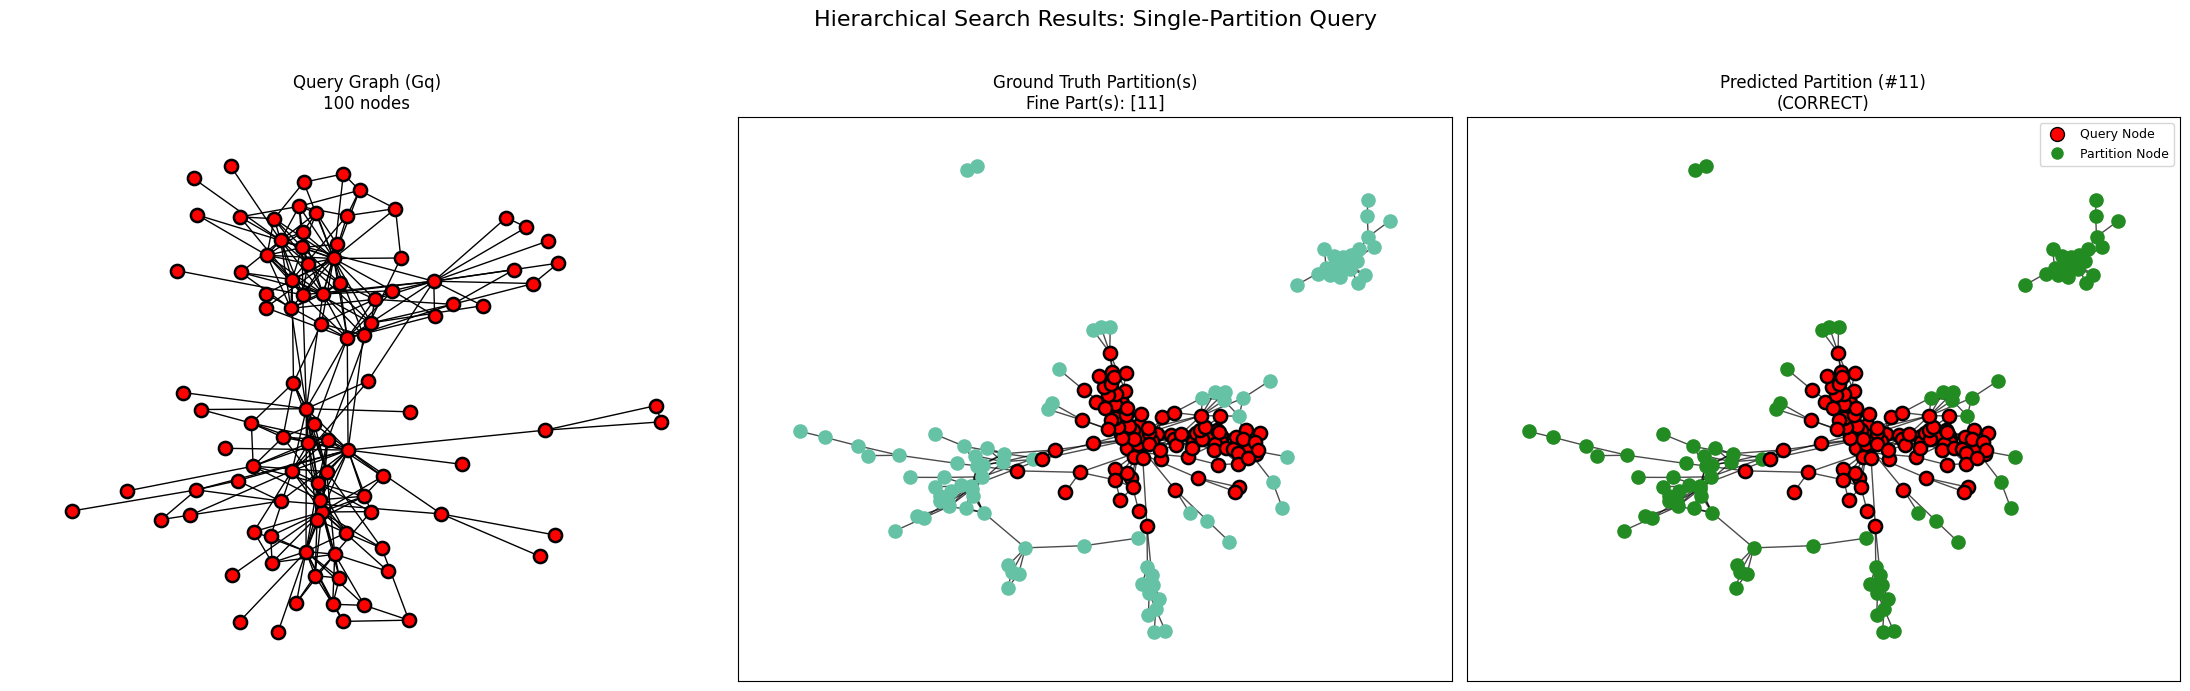

In [ ]:
run_experiment("Single-Partition Query", generate_single_partition_query, context)


######################################################################
###   STARTING EXPERIMENT: Multi-Fine-Partition Query   ###
######################################################################

--- GROUND TRUTH & QUERY DETAILS ---
Query Source Fine Partition(s):  [30, 31, 33]
True Coarse Container(s):          [6]
Generated Query Graph (Gq):        99 nodes

--- STEP 1: COARSE-LEVEL SEARCH ---
Predicted Coarse Partition: Index 6
(CORRECT) Prediction is in the true coarse set [6]. (Dist: 0.239527)
   (Top-5 Matches & Dists: [(6, '0.2395'), (11, '1.4702'), (9, '1.6299'), (19, '1.7690'), (0, '1.8249')] )

--- STEP 2: FINE-LEVEL SEARCH (within predicted coarse partition) ---
Filtered to 5 candidates from coarse part #6.

--- FINAL PREDICTION ---
Predicted Fine Partition: Index 30
(CORRECT) The prediction is one of the source partitions [30, 31, 33]. (Dist: 0.489637)
   (Top-5 Matches & Dists: [(30, '0.4896'), (31, '0.5103'), (33, '0.8448'), (32, '0.9917'), (34, '1.1985')] )

[INF

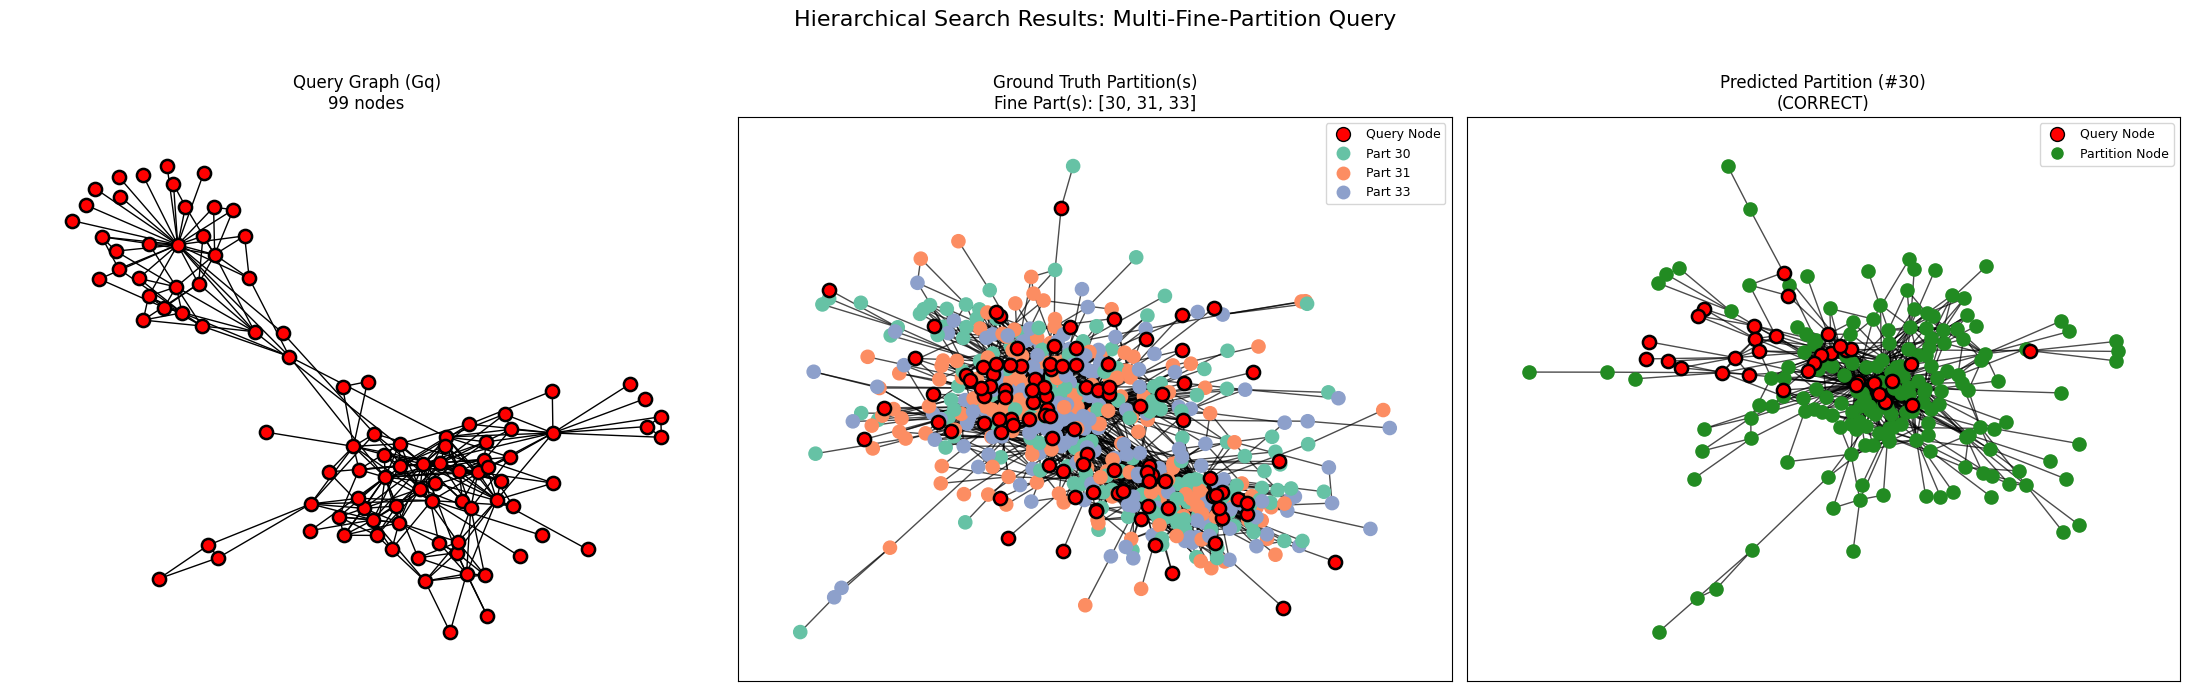

In [ ]:
run_experiment("Multi-Fine-Partition Query", generate_multi_fine_partition_query, context)


######################################################################
###   STARTING EXPERIMENT: Multi-Coarse-Partition Query   ###
######################################################################

--- GROUND TRUTH & QUERY DETAILS ---
Query Source Fine Partition(s):  [32, 40, 43, 49]
True Coarse Container(s):          [6, 8, 9]
Generated Query Graph (Gq):        100 nodes

--- STEP 1: COARSE-LEVEL SEARCH ---
Predicted Coarse Partition: Index 9
(CORRECT) Prediction is in the true coarse set [6, 8, 9]. (Dist: 0.772143)
   (Top-5 Matches & Dists: [(9, '0.7721'), (8, '0.8251'), (3, '1.3404'), (6, '1.5193'), (0, '1.5413')] )

--- STEP 2: FINE-LEVEL SEARCH (within predicted coarse partition) ---
Filtered to 5 candidates from coarse part #9.

--- FINAL PREDICTION ---
Predicted Fine Partition: Index 49
(CORRECT) The prediction is one of the source partitions [32, 40, 43, 49]. (Dist: 0.551564)
   (Top-5 Matches & Dists: [(49, '0.5516'), (47, '1.0878'), (48, '1.3820'), (45, '1.5217'), (4

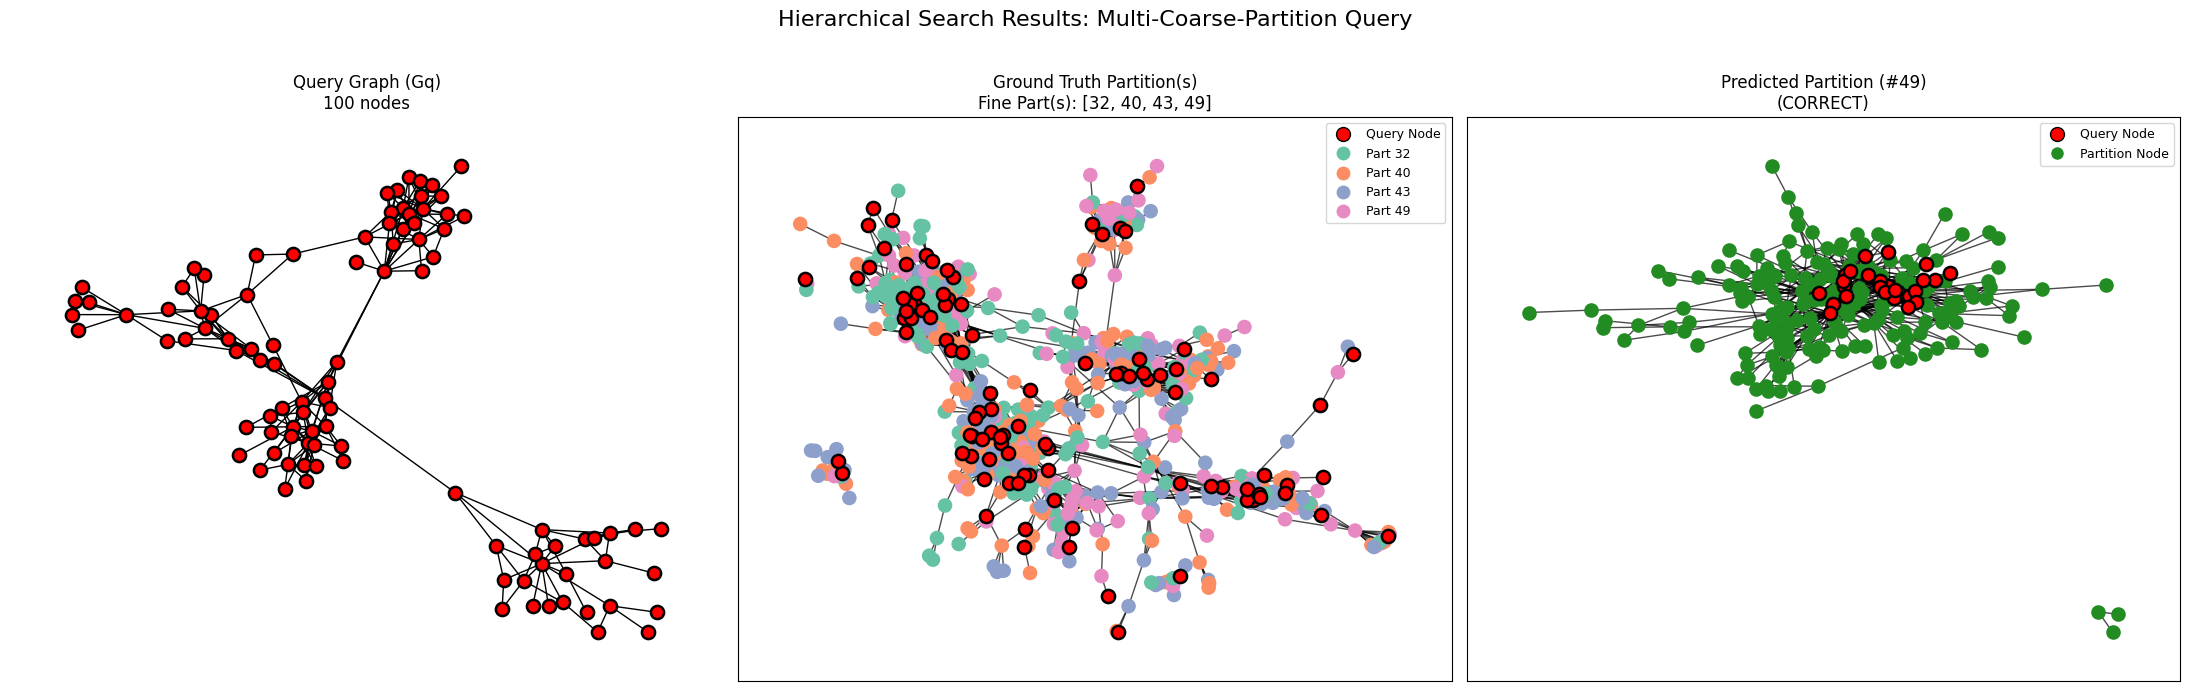

In [ ]:
# Define the generator. The specific configurations (like num_frags and
# min_coarse_parts) are now handled inside the function itself. We only need to
# pass the parameters the function still accepts.
multi_coarse_generator = lambda **ctx: generate_multi_coarse_partition_query(
    min_nodes=80,
    max_nodes=100,
    **ctx
)

# Pass the configured generator to the unchanged run_experiment function.
# The experiment name is updated to reflect that the configuration is now flexible
# and determined internally by the generator.
run_experiment(
    "Multi-Coarse-Partition Query",  # Updated, more general name
    multi_coarse_generator,
    context
)

In [ ]:
# ==============================================================================
# === CORRECTED DETERMINISTIC QUERY GENERATORS                             ===
# ==============================================================================

def generate_single_partition_query_eval(min_nodes=80, max_nodes=100, anchor_coarse_idx=None, budget=50, **kwargs):
    fine_graphs, fine_part_nodes_map, fine_to_coarse_map, original_data = \
        kwargs['fine_graphs'], kwargs['fine_part_nodes_map'], kwargs['fine_to_coarse_map'], kwargs['original_data']

    candidate_fine_indices = [f_idx for f_idx, c_idx in fine_to_coarse_map.items()
                              if c_idx == anchor_coarse_idx and f_idx < len(fine_graphs)
                              and fine_graphs[f_idx] is not None and fine_graphs[f_idx].num_nodes > 0]
    if not candidate_fine_indices:
        raise RuntimeError(f"No valid fine partitions found for anchor {anchor_coarse_idx}.")

    generated_count, seen_query_nodes = 0, set()
    max_attempts = budget * 10
    for _ in range(max_attempts):
        if generated_count >= budget: break
        true_fine_idx = random.choice(candidate_fine_indices)
        anchor_partition = fine_graphs[true_fine_idx]
        local_nodes = _extract_fragment(anchor_partition, max_nodes)

        if local_nodes:
            query_nodes = [fine_part_nodes_map[true_fine_idx][i] for i in local_nodes]
            query_nodes_frozenset = frozenset(query_nodes)
            if query_nodes_frozenset in seen_query_nodes: continue

            Gq, q_global_nodes = _finalize_query_from_nodes(original_data, query_nodes, min_nodes)
            if Gq:
                seen_query_nodes.add(query_nodes_frozenset)
                G_stitched = original_data.subgraph(torch.tensor(fine_part_nodes_map[true_fine_idx], device=device))
                yield Gq, G_stitched, q_global_nodes, {true_fine_idx}, {anchor_coarse_idx}
                generated_count += 1

def generate_multi_fine_partition_query_eval(num_frags=3, min_nodes=80, max_nodes=100, anchor_coarse_idx=None, budget=50, **kwargs):
    G_nx, fine_graphs, fine_part_nodes_map, fine_to_coarse_map, original_data = \
        kwargs['G_nx'], kwargs['fine_graphs'], kwargs['fine_part_nodes_map'], kwargs['fine_to_coarse_map'], kwargs['original_data']

    siblings = [idx for idx, c_idx in fine_to_coarse_map.items() if c_idx == anchor_coarse_idx]
    if len(siblings) < num_frags: return

    generated_count, seen_query_nodes = 0, set()
    max_attempts = budget * 10
    for _ in range(max_attempts):
        if generated_count >= budget: break
        start_fine_idx = random.choice(siblings)
        q_fine_indices, queue, visited = [start_fine_idx], [start_fine_idx], {start_fine_idx}
        search_candidates = list(siblings)
        while queue and len(q_fine_indices) < num_frags:
            current_idx = queue.pop(0)
            random.shuffle(search_candidates)
            for neighbor_idx in search_candidates:
                if neighbor_idx not in visited and are_partitions_neighbors(G_nx, fine_part_nodes_map.get(current_idx), fine_part_nodes_map.get(neighbor_idx)):
                    visited.add(neighbor_idx); queue.append(neighbor_idx); q_fine_indices.append(neighbor_idx)
                    if len(q_fine_indices) >= num_frags: break

        if len(q_fine_indices) < num_frags: continue

        nodes_per_frag, all_query_nodes, possible = max_nodes // num_frags, [], True
        for fine_idx in q_fine_indices:
            if fine_idx >= len(fine_graphs) or fine_graphs[fine_idx] is None: possible = False; break
            local_nodes = _extract_fragment(fine_graphs[fine_idx], nodes_per_frag)
            if not local_nodes: possible = False; break
            all_query_nodes.extend([fine_part_nodes_map[fine_idx][i] for i in local_nodes])

        if not possible: continue
        query_nodes_frozenset = frozenset(all_query_nodes)
        if query_nodes_frozenset in seen_query_nodes: continue

        Gq, q_global_nodes = _finalize_query_from_nodes(original_data, all_query_nodes, min_nodes)
        if Gq:
            seen_query_nodes.add(query_nodes_frozenset)
            stitched_nodes = [node for idx in q_fine_indices for node in fine_part_nodes_map.get(idx, [])]
            G_stitched = original_data.subgraph(torch.tensor(stitched_nodes, device=device))
            yield Gq, G_stitched, q_global_nodes, set(q_fine_indices), {anchor_coarse_idx}
            generated_count += 1

def generate_queries_for_stratum_eval(num_frags, min_coarse_parts, budget, anchor_coarse_idx, **kwargs):
    """
    Generates up to `budget` unique queries for a specific stratum (num_frags, min_coarse_parts),
    constraining the search to start from the `anchor_coarse_idx`.
    """
    G_nx, coarse_part_graph, fine_graphs, fine_part_nodes_map, fine_to_coarse_map, original_data = \
        kwargs['G_nx'], kwargs['coarse_part_graph'], kwargs['fine_graphs'], \
        kwargs['fine_part_nodes_map'], kwargs['fine_to_coarse_map'], kwargs['original_data']
    min_nodes, max_nodes = kwargs.get('min_nodes', 80), kwargs.get('max_nodes', 100)

    # --- FIX STARTS HERE ---
    # Instead of assuming coarse_to_fine_map is passed, we compute it ourselves.
    # This makes the function more robust and self-contained.
    coarse_to_fine_map = defaultdict(list)
    for f_idx, c_idx in fine_to_coarse_map.items():
        coarse_to_fine_map[c_idx].append(f_idx)
    # --- FIX ENDS HERE ---

    possible_start_edges = list(coarse_part_graph.edges(anchor_coarse_idx))
    if not possible_start_edges:
        return 0

    generated_count, seen_query_nodes = 0, set()
    max_attempts = budget * 20
    for _ in range(max_attempts):
        if generated_count >= budget: break

        c_idx1, c_idx2 = random.choice(possible_start_edges)
        fine_in_c1, fine_in_c2 = coarse_to_fine_map.get(c_idx1, []), coarse_to_fine_map.get(c_idx2, [])
        if not fine_in_c1 or not fine_in_c2: continue

        f1, f2 = random.choice(fine_in_c1), random.choice(fine_in_c2)
        if not are_partitions_neighbors(G_nx, fine_part_nodes_map.get(f1), fine_part_nodes_map.get(f2)):
            continue

        q_fine_indices, queue, visited = [f1, f2], [f1, f2], {f1, f2}
        while queue and len(q_fine_indices) < num_frags:
            current_fine_idx = queue.pop(0)
            current_c_idx = fine_to_coarse_map[current_fine_idx]
            coarse_neighbors_and_self = list(coarse_part_graph.neighbors(current_c_idx)) + [current_c_idx]
            potential_fine_neighbors = [fn for c_idx in coarse_neighbors_and_self for fn in coarse_to_fine_map.get(c_idx, [])]
            random.shuffle(potential_fine_neighbors)
            for neighbor_idx in potential_fine_neighbors:
                if neighbor_idx not in visited and are_partitions_neighbors(G_nx, fine_part_nodes_map.get(current_fine_idx), fine_part_nodes_map.get(neighbor_idx)):
                    visited.add(neighbor_idx); queue.append(neighbor_idx); q_fine_indices.append(neighbor_idx)
                    if len(q_fine_indices) >= num_frags: break

        if len(q_fine_indices) < num_frags: continue
        true_coarse_indices = {fine_to_coarse_map[f_idx] for f_idx in q_fine_indices}
        if len(true_coarse_indices) < min_coarse_parts: continue

        nodes_per_frag, all_query_nodes, possible = max_nodes // num_frags, [], True
        for fine_idx in q_fine_indices:
            if fine_idx >= len(fine_graphs) or fine_graphs[fine_idx] is None: possible = False; break
            local_nodes = _extract_fragment(fine_graphs[fine_idx], nodes_per_frag)
            if not local_nodes: possible = False; break
            all_query_nodes.extend([fine_part_nodes_map[fine_idx][i] for i in local_nodes])

        if not possible: continue
        query_nodes_frozenset = frozenset(all_query_nodes)
        if query_nodes_frozenset in seen_query_nodes: continue

        Gq, q_global_nodes = _finalize_query_from_nodes(original_data, all_query_nodes, min_nodes)
        if Gq:
            seen_query_nodes.add(query_nodes_frozenset)
            stitched_node_list = [node for idx in q_fine_indices for node in fine_part_nodes_map.get(idx, [])]
            G_stitched = original_data.subgraph(torch.tensor(stitched_node_list, device=device))
            yield Gq, G_stitched, q_global_nodes, set(q_fine_indices), true_coarse_indices
            generated_count += 1
    return generated_count

# ==============================================================================
# === MAIN EVALUATION LOGIC                                                  ===
# ==============================================================================

def print_summary(results):
    print("\n" + "="*100)
    print("###                                  FINAL PERFORMANCE SUMMARY                                  ###")
    print("="*100)
    print(f"{'Experiment Type':<32} | {'Total Runs':>12} | {'Coarse Acc.':>15} | {'Fine Acc.':>15} | {'Fine+Neigh Acc.':>18}")
    print("-"*100)
    for name, stats in results.items():
        total = stats.get('total_runs', 0)
        coarse = stats.get('coarse_correct', 0)
        fine = stats.get('fine_correct', 0)
        neigh = stats.get('neighbor_correct', 0)
        coarse_acc = (coarse / total) * 100 if total > 0 else 0.0
        fine_acc = (fine / coarse) * 100 if coarse > 0 else 0.0
        fine_plus_neigh_acc = ((fine + neigh) / coarse) * 100 if coarse > 0 else 0.0
        print(f"{name:<32} | {total:>12} | {coarse_acc:>14.2f}% | {fine_acc:>14.2f}% | {fine_plus_neigh_acc:>17.2f}%")
        if stats.get('generation_failures', 0) > 0: print(f"  └─ {'Note:':<8} {stats['generation_failures']} generation errors occurred.")
        if stats.get('skipped_partitions', 0) > 0: print(f"  └─ {'Note:':<8} {stats['skipped_partitions']} partitions were skipped.")
    print("="*100)

def evaluate_query(Gq, true_fine_indices, true_coarse_indices, bucket, context):
    DATASET_NX, faiss_coarse, fine_graphs, fine_to_coarse_map, fine_part_nodes_map = \
        context['G_nx'], context['faiss_coarse'], context['fine_graphs'], context['fine_to_coarse_map'], context['fine_part_nodes_map']

    bucket['total_runs'] += 1
    zq = get_graph_embedding(Gq)
    _, I_coarse = faiss_coarse.search(zq.cpu().numpy(), 1)
    predicted_coarse_idx = I_coarse[0][0].item()
    coarse_correct = predicted_coarse_idx in true_coarse_indices

    if coarse_correct:
        bucket['coarse_correct'] += 1
        candidate_indices = [(f_idx, fine_graphs[f_idx]) for f_idx, c_idx in fine_to_coarse_map.items() if c_idx == predicted_coarse_idx and f_idx < len(fine_graphs)]
        valid_candidates = [(g_idx, fg) for g_idx, fg in candidate_indices if fg is not None and fg.num_nodes > 0]

        if valid_candidates:
            candidate_global_indices, candidate_fine_graphs = zip(*valid_candidates)
            fine_embeddings = torch.cat([get_graph_embedding(fg) for fg in candidate_fine_graphs], dim=0)
            faiss_fine = faiss.IndexFlatL2(16); faiss_fine.add(fine_embeddings.cpu().numpy())
            _, I_fine = faiss_fine.search(zq.cpu().numpy(), 1)
            predicted_fine_global_idx = candidate_global_indices[I_fine[0][0].item()]

            if predicted_fine_global_idx in true_fine_indices:
                bucket['fine_correct'] += 1
            else:
                predicted_nodes = fine_part_nodes_map.get(predicted_fine_global_idx)
                for true_idx in true_fine_indices:
                    if are_partitions_neighbors(DATASET_NX, predicted_nodes, fine_part_nodes_map.get(true_idx)):
                        bucket['neighbor_correct'] += 1; break

def main():

    NUM_TRIALS_PER_PARTITION, PARTITION_TIMEOUT_SECONDS = 50, 300
    num_coarse_partitions = len(context['coarse_graphs'])
    final_results = {}

    simple_experiments = [
        ("Single-Partition Query", lambda **ctx: generate_single_partition_query_eval(**ctx)),
        ("Multi-Fine Query (3 frags)", lambda **ctx: generate_multi_fine_partition_query_eval(num_frags=3, **ctx)),
    ]
    for name, base_generator_func in simple_experiments:
        print(f"\n[INFO] Running evaluation for: {name}")
        experiment_buckets = {c_idx: defaultdict(int) for c_idx in range(num_coarse_partitions)}
        generation_failures, skipped_partitions = 0, set()
        for c_idx_to_anchor in tqdm.tqdm(range(num_coarse_partitions), desc=f"Partitions for {name}", ncols=100):
            partition_start_time = time.time()
            trials_for_this_partition = 0
            try:
                # IMPORTANT: Pass the budget to the generator
                generator = base_generator_func(anchor_coarse_idx=c_idx_to_anchor, budget=NUM_TRIALS_PER_PARTITION, **context)
                for Gq, _, _, true_fine_indices, true_coarse_indices in generator:
                    if time.time() - partition_start_time > PARTITION_TIMEOUT_SECONDS: skipped_partitions.add(c_idx_to_anchor); break
                    # The generator now controls the budget, so this check is redundant but safe
                    if trials_for_this_partition >= NUM_TRIALS_PER_PARTITION: break
                    evaluate_query(Gq, true_fine_indices, true_coarse_indices, experiment_buckets[c_idx_to_anchor], context)
                    trials_for_this_partition += 1
            except (RuntimeError, IndexError) as e:
                generation_failures += 1; skipped_partitions.add(c_idx_to_anchor)
        agg_stats = defaultdict(int); agg_stats["generation_failures"] = generation_failures
        for c_idx, stats in experiment_buckets.items():
            if c_idx not in skipped_partitions:
                for key, val in stats.items(): agg_stats[key] += val
        agg_stats["skipped_partitions"] = len(skipped_partitions); final_results[name] = agg_stats

    name = "Stratified Multi-Coarse"; print(f"\n[INFO] Running evaluation for: {name}")
    multi_coarse_configurations = [(4, 4), (4, 3), (3, 3), (4, 2), (3, 2), (2, 2)]; num_strata = len(multi_coarse_configurations)
    experiment_buckets = {c_idx: defaultdict(int) for c_idx in range(num_coarse_partitions)}
    generation_failures, skipped_partitions = 0, set()
    for c_idx_to_anchor in tqdm.tqdm(range(num_coarse_partitions), desc=f"Partitions for {name}", ncols=100):
        partition_start_time = time.time()
        budget_per_stratum = NUM_TRIALS_PER_PARTITION // num_strata; remaining_budget = NUM_TRIALS_PER_PARTITION % num_strata
        stratum_budgets = [(budget_per_stratum + 1) if i < remaining_budget else budget_per_stratum for i in range(num_strata)]
        try:
            for i, (num_frags, min_coarse_parts) in enumerate(multi_coarse_configurations):
                if time.time() - partition_start_time > PARTITION_TIMEOUT_SECONDS: skipped_partitions.add(c_idx_to_anchor); break
                current_budget = stratum_budgets[i]
                if current_budget == 0: continue
                generated_in_stratum = 0
                # IMPORTANT: Pass the current stratum's budget to the generator
                generator = generate_queries_for_stratum_eval(num_frags, min_coarse_parts, current_budget, c_idx_to_anchor, **context)
                for Gq, _, _, true_fine_indices, true_coarse_indices in generator:
                    evaluate_query(Gq, true_fine_indices, true_coarse_indices, experiment_buckets[c_idx_to_anchor], context)
                    generated_in_stratum += 1
                unused_budget = current_budget - generated_in_stratum
                if unused_budget > 0 and (i + 1) < num_strata: stratum_budgets[i+1] += unused_budget
        except (RuntimeError, IndexError) as e:
            generation_failures += 1; skipped_partitions.add(c_idx_to_anchor)
    agg_stats = defaultdict(int); agg_stats["generation_failures"] = generation_failures
    for c_idx, stats in experiment_buckets.items():
        if c_idx not in skipped_partitions:
            for key, val in stats.items(): agg_stats[key] += val
    agg_stats["skipped_partitions"] = len(skipped_partitions); final_results[name] = agg_stats

    print_summary(final_results)

if __name__ == "__main__":
    main()


[INFO] Running evaluation for: Single-Partition Query


Partitions for Single-Partition Query: 100%|████████████████████████| 20/20 [01:31<00:00,  4.58s/it]



[INFO] Running evaluation for: Multi-Fine Query (3 frags)


Partitions for Multi-Fine Query (3 frags): 100%|████████████████████| 20/20 [02:04<00:00,  6.23s/it]



[INFO] Running evaluation for: Stratified Multi-Coarse


Partitions for Stratified Multi-Coarse: 100%|███████████████████████| 20/20 [04:07<00:00, 12.40s/it]


###                                  FINAL PERFORMANCE SUMMARY                                  ###
Experiment Type                  |   Total Runs |     Coarse Acc. |       Fine Acc. |    Fine+Neigh Acc.
----------------------------------------------------------------------------------------------------
Single-Partition Query           |          956 |         100.00% |         100.00% |            100.00%
Multi-Fine Query (3 frags)       |          966 |         100.00% |          99.28% |            100.00%
Stratified Multi-Coarse          |          980 |          95.61% |          88.05% |             99.79%
